Model features: ['term_date', 'is_holiday', 'day_of_week', 'month', 'day_of_year', 'week_of_year', 'hour', 'weighted_day_of_year', 'year', 'is_month_start', 'is_month_end', 'sin_hour', 'cos_hour', 'sin_day', 'cos_day', 'sin_week', 'cos_week', 'sin_month', 'cos_month', 'is_day', 'day_duration', 'night_duration']
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.91 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] lambda_l2 is set=3.0, reg_lambda=0.2 will be ignored. Current value: lambda_l2=3.0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=0.5 will be ignored. Current value: bagging_fraction=0.5


C:\Users\ginap\AppData\Local\Temp\ipykernel_81628\585910091.py:90: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, end=end_date, freq='H')


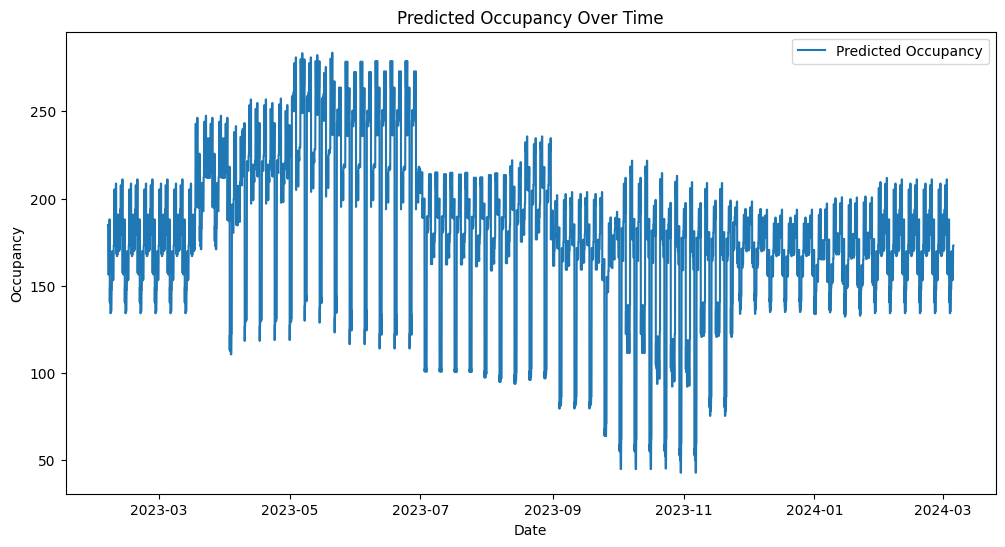

In [16]:
import numpy as np
import pandas as pd
from datetime import datetime
from pandas.tseries.holiday import (
    AbstractHolidayCalendar, DateOffset, GoodFriday, EasterMonday, Holiday, MO
)
import joblib
import matplotlib.pyplot as plt

# Define the VancouverHolidayCalendar class
class VancouverHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('New Years Day', month=1, day=1),
        Holiday('Family Day', month=2, day=1, offset=DateOffset(weekday=MO(3))),
        GoodFriday,
        EasterMonday,
        Holiday('Victoria Day', month=5, day=25, offset=DateOffset(weekday=MO(-1))),
        Holiday('Canada Day', month=7, day=1),
        Holiday('Labour Day', month=9, day=1, offset=DateOffset(weekday=MO(1))),
        Holiday('National Day for Truth and Reconciliation', month=9, day=30),
        Holiday('Thanksgiving', month=10, day=1, offset=DateOffset(weekday=MO(2))),
        Holiday('Remembrance Day', month=11, day=11),
        Holiday('Christmas Eve', month=12, day=24),
        Holiday('Christmas Day', month=12, day=25),
        Holiday('Boxing Day', month=12, day=26),
        Holiday('Additional Holiday 1', month=12, day=27),
        Holiday('Additional Holiday 2', month=12, day=28),
        Holiday('Additional Holiday 3', month=12, day=29),
        Holiday('Additional Holiday 4', month=12, day=30),
        Holiday('New Years Eve', month=12, day=31)
    ]

# Function to create features from the datetime index
def create_features(df, label=None):
            """
            Create time series features from the datetime index
            """
            df = df.copy()

            df['date'] = df.index
            df['month'] = df['date'].dt.month
            df['day_of_year'] = df['date'].dt.dayofyear
            df['week_of_year'] = df['date'].dt.isocalendar().week
            df['day_of_week'] = df['date'].dt.dayofweek
            df['hour'] = df['date'].dt.hour  # Add hour feature

            # Apply weight to the day_of_year column
            weight = 100  # You can adjust this weight as needed
            df['weighted_day_of_year'] = df['day_of_year'] * weight
            
            df['year'] = df['date'].dt.year
            df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
            df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
            
            # Seasonality features
            df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
            df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)
            df['sin_day'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
            df['cos_day'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)
            df['sin_week'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
            df['cos_week'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
            df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
            df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)

            # Seasonal indices (if applicable)
            # Autoregressive features (if applicable)
            # Time since last event (if applicable)
            # Day/night indicator
            df['is_day'] = np.where((df['hour'] >= 6) & (df['hour'] <= 18), 1, 0)
            
            # Day/night duration
            df['day_duration'] = np.where(df['is_day'] == 1, 12 - df['hour'], 0)
            df['night_duration'] = np.where(df['is_day'] == 0, df['hour'], 0)
            
            # Weather data (if available)
            # Special event indicators (if applicable)
            # Trend features (if applicable)

            df['term_date'] = False
            
            return df

def add_holidays(df):
    cal = VancouverHolidayCalendar()
    holidays = cal.holidays(start=df.index.min(), end=df.index.max())
    df['is_holiday'] = df.index.isin(holidays)
    return df

def main(start_date, end_date, model_path):
    date_range = pd.date_range(start=start_date, end=end_date, freq='H')
    df = pd.DataFrame(index=date_range)

    df = create_features(df)
    df['is_holiday'] = False
    #df = add_holidays(df)

    # Load the LightGBM model
    model = joblib.load(model_path)

    # Select the feature columns for prediction
    feature_cols = ['month', 'day_of_year', 'week_of_year', 'day_of_week', 'hour',
                    'weighted_day_of_year', 'year', 'is_month_start', 'is_month_end',
                    'sin_hour', 'cos_hour', 'sin_day', 'cos_day', 'sin_week', 'cos_week',
                    'sin_month', 'cos_month', 'is_day', 'day_duration', 'night_duration',
                    'is_holiday', 'term_date']
    X = df[feature_cols]

    # Make predictions and store them in a separate list
    predictions = model.predict(X).tolist()

    return df, df.index, predictions


# Example usage
start_date = "2023-02-05 03:00:00"
end_date = "2024-03-05 23:00:00"
model_path = 'trained_model.joblib'
model = joblib.load(model_path)
print("Model features:", model.booster_.feature_name())

df, dates, predictions = main(start_date, end_date, model_path)

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(dates, predictions, label='Predicted Occupancy')
plt.xlabel('Date')
plt.ylabel('Occupancy')
plt.title('Predicted Occupancy Over Time')
plt.legend()
plt.show()


In [15]:
df

,date,month,day_of_year,week_of_year,day_of_week,hour,weighted_day_of_year,year,is_month_start,is_month_end,...,cos_day,sin_week,cos_week,sin_month,cos_month,is_day,day_duration,night_duration,term_date,is_holiday
2023-02-05 03:00:00,2023-02-05 03:00:00,2,36,5,6,3,3600,2023,0,0,...,0.814292,-0.781831,0.62349,0.866025,5.000000e-01,0,0,3,False,False
2023-02-05 04:00:00,2023-02-05 04:00:00,2,36,5,6,4,3600,2023,0,0,...,0.814292,-0.781831,0.62349,0.866025,5.000000e-01,0,0,4,False,False
2023-02-05 05:00:00,2023-02-05 05:00:00,2,36,5,6,5,3600,2023,0,0,...,0.814292,-0.781831,0.62349,0.866025,5.000000e-01,0,0,5,False,False
2023-02-05 06:00:00,2023-02-05 06:00:00,2,36,5,6,6,3600,2023,0,0,...,0.814292,-0.781831,0.62349,0.866025,5.000000e-01,1,6,0,False,False
2023-02-05 07:00:00,2023-02-05 07:00:00,2,36,5,6,7,3600,2023,0,0,...,0.814292,-0.781831,0.62349,0.866025,5.000000e-01,1,5,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-05 19:00:00,2024-03-05 19:00:00,3,65,10,1,19,6500,2024,0,0,...,0.437340,0.781831,0.62349,1.000000,6.123234e-17,0,0,19,False,False
2024-03-05 20:00:00,2024-03-05 20:00:00,3,65,10,1,20,6500,2024,0,0,...,0.437340,0.781831,0.62349,1.000000,6.123234e-17,0,0,20,False,False
2024-03-05 21:00:00,2024-03-05 21:00:00,3,65,10,1,21,6500,2024,0,0,...,0.437340,0.781831,0.62349,1.000000,6.123234e-17,0,0,21,False,False
2024-03-05 22:00:00,2024-03-05 22:00:00,3,65,10,1,22,6500,2024,0,0,...,0.437340,0.781831,0.62349,1.000000,6.123234e-17,0,0,22,False,False
